# Extended Kalman Filter

Guessing the posterior after it moves.

Non-linear motion model:

$\begin{bmatrix}x' \\ y' \\ \theta \end{bmatrix} = \begin{bmatrix} x+cos\theta \\ y+sin\theta \\ \theta \end{bmatrix}$

Our initial estimate is given as:

$\Sigma_0 = \begin{bmatrix} 0.01 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 10000\end{bmatrix}$

$\mu_0 = [0,0,0]$


The posterior will likely be a ring. We know that the robot moved 1 unit. So let's say it moved in the x direction. Our covariance tells us that we know the x and y state variables with good certainty. However the rotation has very high variance.

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

In [2]:
import numpy.random
def SimulateMotion(meanTranslation, covTranslation, meanRotation, varRotation, sampleSize):
    translation = numpy.random.multivariate_normal(meanTranslation, covTranslation, sampleSize)
    rotation = numpy.random.multivariate_normal(meanRotation, numpy.identity(1)*varRotation, sampleSize)
    return numpy.concatenate((
        translation[:,0:1] + np.cos(rotation),
        translation[:,1:2] + np.sin(rotation)), 1)

In [3]:
def plotSim(sim):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(sim[:,:1], sim[:,1:2], 'b.', markersize=1)
    
    major_ticks = np.arange(-2, 2.5, 1)
    minor_ticks = np.arange(-2, 2.5, 0.5)
    
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plt.show()

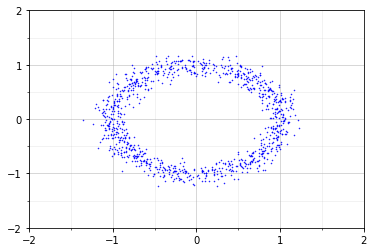

In [4]:
sim = SimulateMotion(np.array([0,0]), np.array([[0.01, 0.],[0., 0.01]]), np.array([0]), np.array([10000]), 1000)
plotSim(sim)

### What if the rotation covariance was lower?

$\sigma^2_\theta=0.5$

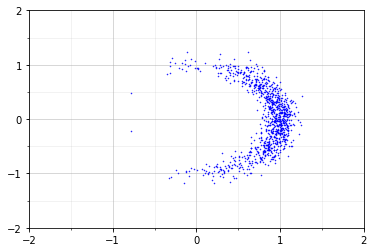

In [5]:
sim = SimulateMotion(np.array([0,0]), np.array([[0.01, 0.],[0., 0.01]]), np.array([0]), np.array([0.5]), 1000)
plotSim(sim)

$\sigma^2_\theta=0.1$

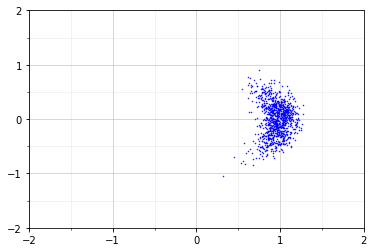

In [6]:
sim = SimulateMotion(np.array([0,0]), np.array([[0.01, 0.],[0., 0.01]]), np.array([0]), np.array([0.1]), 1000)
plotSim(sim)

### Deriving the prediction step

The state transition function can be written as

$x_t = g(u_t, x_{t-1}) + \epsilon_t$

The linearization equation is

$g(u_t, x_{t-1}) = g(u_t, \mu_{t-1}) + g'(u_t, \mu_{t-1})(x_{t-1}-\mu_{t-1})$

The Jacobian will be

$\frac{\partial g(u_t, x_{t-1})}{\partial x_{x-1}} = 
\begin{bmatrix} 1 & 0 & -sin\theta \\ 0 & 1 &cos\theta \\ 0 & 0 & 1 \end{bmatrix}$

This part is easier to understand if you skip ahead and read the EKF derivation in Section 7.4.3

In [7]:
# Jacobian
def Gt(mean_prev):
    theta = mean_prev[0]
    return np.array([[1, 0, -np.sin(theta)], [0, 1, np.cos(theta)], [0, 0, 1]])

In [8]:
def Prediction(mean_prev, cov_prev, control):
    mean_predict = mean_prev + control
    
    G_prev = Gt(mean_prev)
    cov_predict = G_prev.dot(cov_prev).dot(G_prev.transpose())
    
    return mean_predict, cov_predict

In [9]:
def drawEllipse(center, covariance):
    [eigValues_predict, eigVectors_predict] = LA.eig(covariance)
    #print([eigValues_predict, eigVectors_predict])
    
    ellipseWidth = 2 * math.sqrt(eigValues_predict[0] * 5.991)
    ellipseHeight = 2 * math.sqrt(eigValues_predict[1] * 5.991)
    angle = math.atan(eigVectors_predict[1,0]/eigVectors_predict[0,0])
    angleDegree = angle*180/math.pi

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, aspect='equal')
    e1=Ellipse(center, ellipseWidth, ellipseHeight, angleDegree, label="prediction")
    ax.add_patch(e1)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    plt.grid(True)

    plt.show()

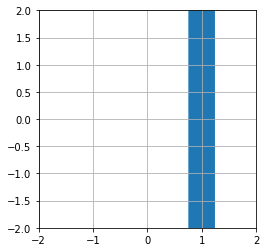

In [10]:
cov_prev = np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 10000]])
mean_prev = np.array([0, 0, 0])

# move in x
control = np.array([1, 0, 0])

[mean, cov] = Prediction(mean_prev, cov_prev, control)

mean = mean[:2]
cov =  cov[:2, :2]
#print("Mean:\n", mean)
#print("Covariance:\n", cov)
drawEllipse(mean, cov)

### What if the rotation covariance was lower?

#### $\sigma^2_\theta = 0.5$

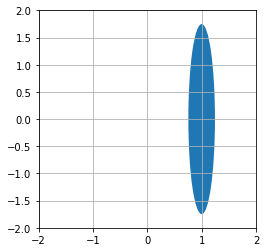

In [11]:
cov_prev = np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.5]])
mean_prev = np.array([0, 0, 0])

# move in x
control = np.array([1, 0, 0])

[mean, cov] = Prediction(mean_prev, cov_prev, control)

mean = mean[:2]
cov =  cov[:2, :2]
#print("Mean:\n", mean)
#print("Covariance:\n", cov)
drawEllipse(mean, cov)

#### $\sigma^2_\theta = 0.1 $

Mean:
 [1 0]
Covariance:
 [[0.01 0.  ]
 [0.   0.11]]


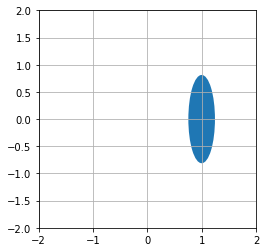

In [12]:
cov_prev = np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.1]])
mean_prev = np.array([0, 0, 0])

# move in x
control = np.array([1, 0, 0])

[mean, cov] = Prediction(mean_prev, cov_prev, control)

mean = mean[:2]
cov =  cov[:2, :2]
print("Mean:\n", mean)
print("Covariance:\n", cov)
drawEllipse(mean, cov)

### Measurement Model

According to the question we can only measure $x$ with a variance of $Q_t =0.01$.
There is no non-linearity in our measurement model. We can use a linear update step.

In [13]:
def Update(meanPredict, covPredict, C, Qt, zt):
    Kp = C.dot(covPredict).dot(C.transpose()) + Qt
    K = covPredict.dot(C.transpose())/Kp
    K.shape = (3, 1) # this and the next two lines are to force col and row vectors
    C.shape = (1, 3)
    meanPredict.shape = (3,1)
    mean = meanPredict + K * (zt - C.dot(meanPredict))
    covp = (np.identity(3) - K.dot(C))
    cov = covp.dot(covPredict)
    return mean, cov

Let's say we measurered,

$z_{t=1,x} = 0.95$

meanPredict
 [1 0 0]
covPredict
 [[0.01 0.   0.  ]
 [0.   0.11 0.1 ]
 [0.   0.1  0.1 ]]
meanUpdate
 [[0.975]
 [0.   ]
 [0.   ]]
covUpdate
 [[0.005 0.    0.   ]
 [0.    0.11  0.1  ]
 [0.    0.1   0.1  ]]


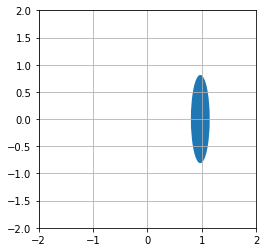

In [14]:
covPrior = np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.1]])
meanPrior = np.array([0, 0, 0])

# move in x
control = np.array([1, 0, 0])

[meanPredict, covPredict] = Prediction(meanPrior, covPrior, control)

print("meanPredict\n", meanPredict)
print("covPredict\n", covPredict)

[meanUpdate, covUpdate] = Update(meanPredict, covPredict, np.array([1, 0, 0]), np.array([0.01]), np.array([0.95]))
print("meanUpdate\n", meanUpdate)
print("covUpdate\n", covUpdate)
mean = meanUpdate[:2]
cov =  covUpdate[:2, :2]
drawEllipse(mean, cov)

### Overlay the prediction and update
$\sigma^2_\theta=0.1$

$z_{t,x}=0.95$

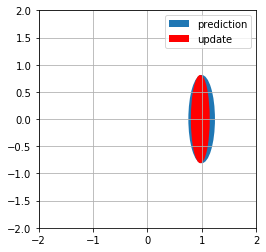

In [15]:
# get the x,y from the prediction and update
meanPredictXY = meanPredict[:2]
covPredictXY = covPredict[:2, :2]
meanUpdateXY = meanUpdate[:2]
covUpdateXY =  covUpdate[:2, :2]


[eigValues_predict, eigVectors_predict] = LA.eig(covPredictXY)

ellipseWidth = 2 * math.sqrt(eigValues_predict[0] * 5.991)
ellipseHeight = 2 * math.sqrt(eigValues_predict[1] * 5.991)
angle = math.atan(eigVectors_predict[1,0]/eigVectors_predict[0,0])
angleDegree = angle*180/math.pi

fig = plt.figure()
ax = fig.add_subplot(1,1,1, aspect='equal')
e1=Ellipse(meanPredictXY, ellipseWidth, ellipseHeight, angleDegree, label="prediction")
ax.add_patch(e1)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.grid(True)

[eigValues_update, eigVectors_update] = LA.eig(covUpdateXY)

ellipseWidth = 2 * math.sqrt(eigValues_update[0] * 5.991)
ellipseHeight = 2 * math.sqrt(eigValues_update[1] * 5.991)
angle = math.atan(eigVectors_update[1,0]/eigVectors_update[0,0])
angleDegree = angle*180/math.pi

e2=Ellipse(meanUpdateXY, ellipseWidth, ellipseHeight, angleDegree, facecolor='red', label="update")
ax.add_patch(e2)
plt.legend()

plt.show()